# CREMI Dataset
#### Team: Benedict Au, Amanda Zang, Jenny Zhen
#### Apr 1, 2020

In [1]:
import h5py
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. CREMI Data Format Specification

Three datasets, each consisting of two $(5 \mu m)^3$ volumes (training and testing, each 1250 px × 1250 px × 125 px) of serial section EM of the adult fly brain.

### In each slice plane, each pixel represents $(4 \, nm)^2$ and has thickness of $40 \, nm$.


Volumes and annotations are stored in a single HDF5 file with the following datasets:

#### Volumes
The volumes are stored in row-major format, i.e., with dimensions (depth,height,width). All volumes have an attribute resolution that specifies the size of voxels (depth,height,width) in nm. In the padded versions of the datasets, the raw volume provides much more context. In this case, the label volumes have an additional offset attribute (z,y,x) in nm that marks the beginning of the label volumes in the raw volume.

- `volumes/raw`: gray scale pixels
- `volumes/labels/clefts`: synaptic cleft segmentation
- `volumes/labels/neuron_ids`: neuron segmentation

#### Annotations
Annotations for pre- and post-synaptic partner pairs are provided as well. All locations are given as (z,y,x) in nm. In the padded versions of the datasets, the raw volume provides much more context. In this case, the annotation group has an additional offset attribute (z,y,x) in nm, which is the same as for the label volumes. All locations are relative to this offset, such that they are the same as in the unpadded version.

- `annotations/ids`: list of ids
- `annotations/locations`: list of annotation locations as (z,y,x) in nm, same order as ids
- `annotations/type`: list of annotation types (presynaptic_site or postsynaptic_site), same order as ids
- `presynaptic_site/partners`: list of id tuples (pre, post) linking pre- and postsynaptic partners
- `comments/target_ids`: list of ids for annotations that have a comment
- `comments/comments`: list of comments, same order as target_ids

### Viewing CREMI dataset hdf5 file hierarchy

In h5py, groups work like dictionaries, and datasets work like NumPy arrays. 

Here is the file hierarchy of Sample A:

In [2]:
filename = "./data_cremi/sample_A_20160501.hdf"
f = h5py.File(filename, 'r')

os.system("h5dump -n ./data_cremi/sample_A_20160501.hdf")
result = subprocess.run(["h5dump", "-n", filename], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

HDF5 "./data_cremi/sample_A_20160501.hdf" {
FILE_CONTENTS {
 group      /
 group      /__DATA_TYPES__
 datatype   /__DATA_TYPES__/Enum_Boolean
 datatype   /__DATA_TYPES__/String_VariableLength
 group      /annotations
 group      /annotations/comments
 dataset    /annotations/comments/comments
 dataset    /annotations/comments/target_ids
 dataset    /annotations/ids
 dataset    /annotations/locations
 group      /annotations/presynaptic_site
 dataset    /annotations/presynaptic_site/partners
 dataset    /annotations/types
 group      /volumes
 group      /volumes/labels
 dataset    /volumes/labels/clefts
 dataset    /volumes/labels/neuron_ids
 dataset    /volumes/raw
 }
}



In greater detail:

## 2. Volumes EDA: raw, clefts, neuron_ids datasets


### 2.1 Plot one slice

Visualise one slice of raw data, clefts labels and neuron_ids labels:

In [3]:
raw = f["/volumes/raw"]
clefts = f["/volumes/labels/clefts"]
neuron_ids = f["/volumes/labels/neuron_ids"]

img = (raw, clefts, neuron_ids)


In [13]:
np.min(raw)

0

Dataset dimensions: (125, 1250, 1250) 

Layer 0: 

[[118 111 103 ... 151 152 149]
 [112 102 102 ... 146 150 147]
 [110 105 105 ... 147 141 135]
 ...
 [108 106 115 ... 160 158 151]
 [113 113 125 ... 158 152 148]
 [117 121 125 ... 152 146 146]] 



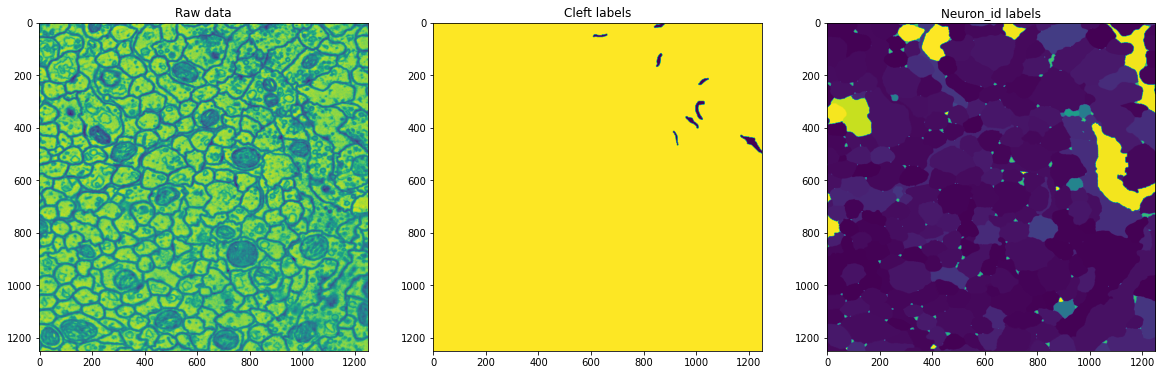

In [15]:
layer = 0

raw_layer = raw[layer]
clefts_layer = clefts[layer]
neuron_ids_layer = neuron_ids[layer]

print("Dataset dimensions: {}".format(raw.shape), "\n")
print("Layer {}: \n".format(layer))
print(raw_layer, "\n")

fig, axarr = plt.subplots(1,3,figsize=(20,20))

axarr[0].imshow(raw_layer)
axarr[0].title.set_text('Raw data')
axarr[1].imshow(clefts_layer)
axarr[1].title.set_text('Cleft labels')
axarr[2].imshow(neuron_ids_layer)
axarr[2].title.set_text('Neuron_id labels')

### 2.2 Plot all slices


### 2.3 Plot single neuron in all slices 


A few observations regarding the raw data slices:

1. Slices of the raw data have varying levels of brightness/saturation, e.g. slice 18 vs 19. 
2. Some slices are not in focus, e.g. 22.
2. Contrast/sharpness can vary within a slice, e.g. 109-113.
3. Some slices have artifacts, e.g. 29, 50. 


### 2.4 Distributions

Dataset: Raw
Shape: (125, 1250, 1250)
Number of pixels: 195,312,500
Min: 0
Max: 255
Mean: 1.258e+02
Variance: 7.961e+02
Skewness: -4.060e-01
kurtosis: -9.580e-01
Unique values: 250



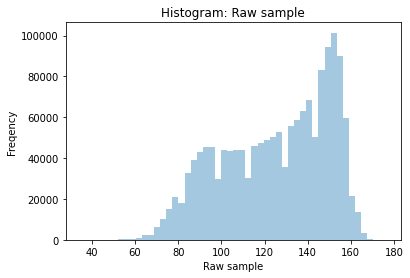



Dataset: Clefts
Shape: (125, 1250, 1250)
Number of pixels: 195,312,500
Min: 604
Max: 18,446,744,073,709,551,615
Mean: 1.841e+19
Variance: 7.659e+35
Skewness: -2.098e+01
kurtosis: 4.383e+02
Unique values: 124



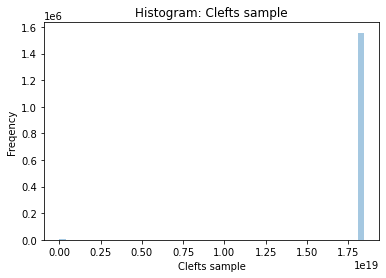



Dataset: Neuron_ids
Shape: (125, 1250, 1250)
Number of pixels: 195,312,500
Min: 885
Max: 191,978
Mean: 1.970e+04
Variance: 1.459e+09
Skewness: 3.535e+00
kurtosis: 1.183e+01
Unique values: 37366



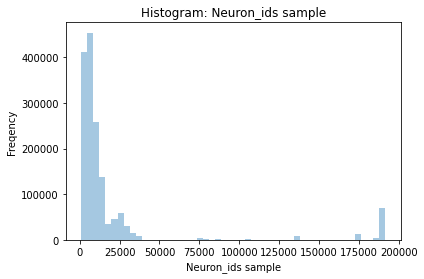

In [17]:
from scipy import stats

datasets = [raw, clefts, neuron_ids]
dataset_names = ["Raw", "Clefts", "Neuron_ids"]

for dataset, dataset_name in zip(datasets, dataset_names):
    print("Dataset: {}".format(dataset_name))
    print("Shape: {}".format(dataset.shape))
    dataset_flat = dataset[:].flatten()
    print("Number of pixels: {:,}".format(len(dataset_flat)))
    
    # Descriptive stats
    des = stats.describe(dataset_flat)
    print("Min: {:,}".format(des.minmax[0]))
    print("Max: {:,}".format(des.minmax[1]))
    print("Mean: {0:1.3e}".format(des.mean))
    print("Variance: {0:1.3e}".format(des.variance))
    print("Skewness: {0:1.3e}".format(des.skewness))
    print("kurtosis: {0:1.3e}".format(des.kurtosis))
    print("Unique values: {}\n".format(len(np.unique(dataset_flat))))
    
    # Sampling to visualise
    dataset_sample = dataset[0] # take first slice as sample 
    # dataset_sample = np.random.choice(
    #     dataset_flat, int(0.01*len(dataset_flat))) # take 1% of vol as sample
    f, ax = plt.subplots(figsize=(6, 4))
    ax = sns.distplot(dataset_sample, axlabel="{} sample".format(dataset_name), kde=False, rug=False)
    ax.set_title('Histogram: {} sample'.format(dataset_name))
    ax.set_ylabel('Freqency')
    plt.show();
    
    print("\n")

## 3. Neuroglancer



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
import h5py
import numpy as np
# from ffn.inference import storage
# from ffn.inference.segmentation import clear_dust, make_labels_contiguous, clean_up
from cc3d import connected_components
import neuroglancer
import cloudvolume
def hdf5_to_cloudvolume():
    pass
import matplotlib.pyplot as plt

### INPUT

In [5]:
#RAW data information
raw_data = '/Users/benedictau/Documents/SCHOOL/UChicago/Capstone/data_cremi/sample_A_20160501.hdf'
raw_data_dset = 'image' #usually don't change

##FFN segmentation information
# seg_folder = './results/inference_01/'
# seg_seed = (0,0,0)

#RESOLUTION information
xy_res = 1250
z_res = 125

#PROCESSING information
cleanup = 0 #0 for nothing , 1 for SS-RAF, 2 for michal, 3 for michal+raf
min_particle = 10


In [6]:
h5file = h5py.File(raw_data, 'r')
image = h5file["/volumes/raw"]
print('Raw data info:')
print(image.shape, image.dtype)


Raw data info:
(125, 1250, 1250) uint8


In [7]:
seg = h5file["/volumes/labels/neuron_ids"]
print('Label data info:')
print(seg.shape, seg.dtype)

Label data info:
(125, 1250, 1250) uint64


### VISUALISATION

In [12]:
#neuroglancer.set_server_bind_address(bind_address='127.0.0.1', bind_port=4000)
#neuroglancer.server.start()
viewer = neuroglancer.Viewer()
dimensions = neuroglancer.CoordinateSpace(
    names=['z', 'y', 'x'], units='nm', scales=[40, 4 ,4])
with viewer.txn() as s:
    s.layers['image'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=image, 
            dimensions=dimensions, 
            volume_type='image', 
            max_downsampling=4
        )
    )
    s.layers['seg'] = neuroglancer.SegmentationLayer(
        source=neuroglancer.LocalVolume(
            data=seg, 
            dimensions=dimensions, 
            volume_type='segmentation',
            max_downsampling=4
        )
    )
print(viewer)

http://127.0.0.1:60840/v/5a2b761802c42a92c3ba76a007e720f9fcec1b35/


In [11]:
del(viewer)